## Скачиваем данные

```
mkdir ./data
wget https://s3-us-west-2.amazonaws.com/lenta-news-dataset/news_lenta.csv -O ./data/lenta_data.csv
```

In [ ]:
import nltk
nltk.download('stopwords')


------------

## Пример использования токенайзера

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import string
from tqdm import tqdm_notebook as tqdm
from sklearn.base import TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn import metrics
from collections import Counter
from nltk.corpus import stopwords
from spacy.symbols import PRON
from ru2 import Russian2
from sklearn.model_selection import train_test_split
stopwords = stopwords.words('russian')

import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

from linguistics import Linguistic

In [3]:
df = pd.read_csv('./data/lenta_data.csv')
df.head()

,tags,text,title,topic,url
0,Общество,Миллиардер Илон Маск в резкой форме ответил бр...,Илон Маск назвал педофилом спасавшего детей из...,Мир,https://lenta.ru/news/2018/07/16/su57/
1,Рынки,США и их западные союзники рассматривают возмо...,США задумались о распечатывании нефтяного резерва,Экономика,https://lenta.ru/news/2018/07/16/foes/
2,Преступность,Празднование победы сборной Франции на чемпион...,Празднование победы на ЧМ во Франции закончило...,Мир,https://lenta.ru/news/2018/07/15/fra_bezumie/
3,Политика,География использования лимузинов проекта «Кор...,Песков рассказал о планах на президентские лим...,Россия,https://lenta.ru/news/2018/07/16/delo_shyut/
4,Музыка,Американская поп-певица Бритни Спирс случайно ...,Грудь Бритни Спирс вновь выскочила из лифчика ...,Культура,https://lenta.ru/news/2018/07/16/pedomusk/


In [4]:
df = df[['title','topic']]
df.tail()


,title,topic
699741,Леворадикалы создают предвыборный блок,Россия
699742,Литва засудила участников переворота 91 года,Мир
699743,Коржаков готов рассказать Генпрокуратуре про ф...,Россия
699744,Еще одно землетрясение в Турции: один человек ...,Мир
699745,Киргизия ведет бои на границах с Таджикистаном...,Мир


In [5]:
df.groupby('topic',group_keys=False)['title'].count().sort_values(ascending=False)

topic
Россия               158072
Мир                  134334
Экономика             77673
Спорт                 62463
Культура              52600
Бывший СССР           52018
Наука и техника       51869
Интернет и СМИ        43313
Из жизни              26356
Силовые структуры     18480
Бизнес                 7398
Ценности               6832
Путешествия            6045
69-я параллель         1095
Крым                    666
Культпросвет            340
Легпром                 114
Библиотека               65
Дом                       6
Оружие                    3
ЧМ-2014                   2
Сочи                      1
МедНовости                1
Name: title, dtype: int64

Будем работать с двумя топиками: Россия и Мир

In [6]:
df=df[df['topic'].isin(['Россия','Мир'])]

In [7]:
train, test = train_test_split(df, test_size=0.33, random_state=42)
print('Размерность данных для тренировки:', train.shape)
print('Размерность данных для тестирования:', test.shape)


Размерность данных для тренировки: (195912, 2)
Размерность данных для тестирования: (96494, 2)


In [8]:
STOPLIST = set(stopwords)
SYMBOLS = " ".join(string.punctuation).split(" ") + ["-", "...", "”", "”","«","»"]
ru_nlp = Russian2()
ru_nlp.add_pipe(ru_nlp.create_pipe('sentencizer'))
ling=Linguistic(ru_nlp, STOPLIST, punctuations=SYMBOLS)

In [9]:
ru_text = [text for text in train[train['topic'] == 'Россия']['title']]
world_text = [text for text in train[train['topic'] == 'Мир']['title']]


In [10]:
ru_clean = pd.Series(ling.cleanup(ru_text,show_progress=tqdm))
ru_clean = ' '.join(ru_clean).split()

world_clean = pd.Series(ling.cleanup(world_text,show_progress=tqdm))
world_clean = ' '.join(world_clean).split()

HBox(children=(IntProgress(value=0, max=105927), HTML(value='')))

HBox(children=(IntProgress(value=0, max=89985), HTML(value='')))

In [11]:
ru_counts = Counter(ru_clean)
world_counts = Counter(world_clean)

ru_common_words = [word[0] for word in ru_counts.most_common(20)]
ru_common_counts = [word[1] for word in ru_counts.most_common(20)]

world_common_words = [word[0] for word in world_counts.most_common(20)]
world_common_counts = [word[1] for word in world_counts.most_common(20)]

In [12]:
def plot_top(common_word,common_counts,name):
    fig = plt.figure(figsize=(18,6))
    sns.barplot(x=common_word, y=common_counts)
    plt.title('Наиболее распространенные слова, используемые в текстах по теме %s' % name)
    plt.show();

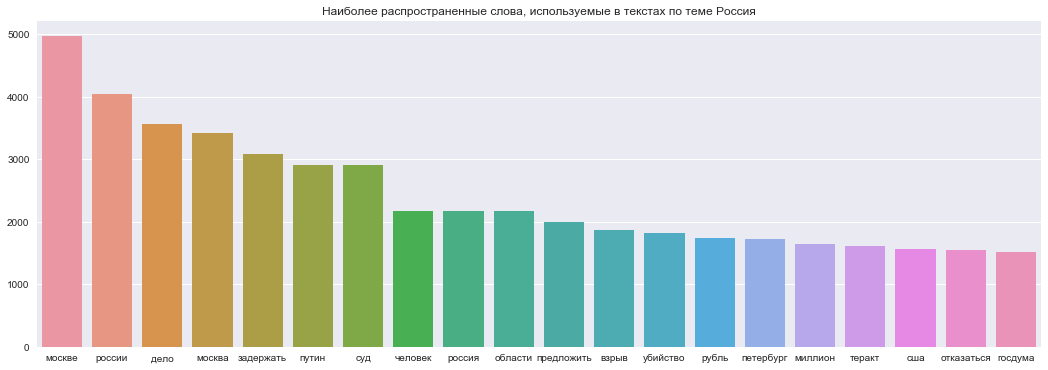

In [13]:
plot_top(ru_common_words,ru_common_counts, 'Россия')

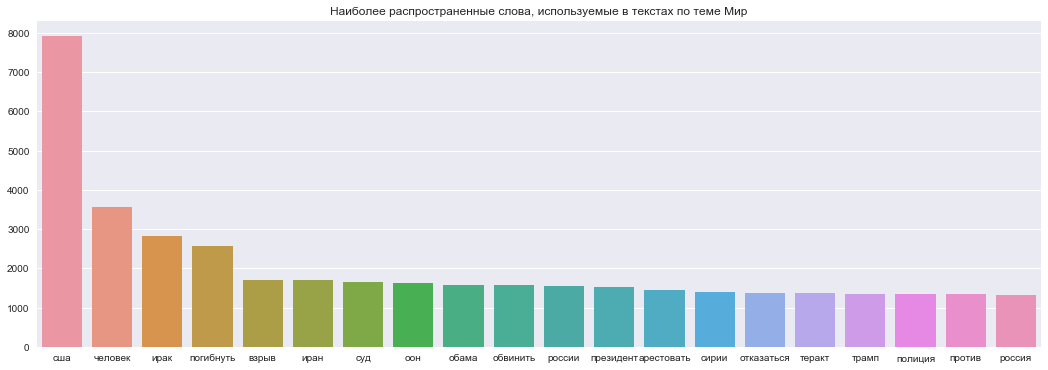

In [14]:
plot_top(world_common_words, world_common_counts, 'Мир')

In [15]:
class CleanTextTransformer(TransformerMixin):
    
    def transform(self, X, **transform_params):
        return [cleanText(text) for text in X]
    
    def fit(self, X, y=None, **fit_params):
        return self
    
    def get_params(self, deep=True):
        return {}
    
def cleanText(text):
    text = text.strip().replace("\n", " ").replace("\r"," ")
    text = text.lower()
    return text

def tokenizeText(text):
    tokens = ru_nlp(text)
    lemmas = []
    for tok in tokens:
        lemmas.append(tok.lemma_.lower().strip() if tok.lemma_ != PRON else tok.lower_)
    tokens = lemmas
    tokens = [tok for tok in tokens if tok not in STOPLIST]
    tokens = [tok for tok in tokens if tok not in SYMBOLS]
    return tokens

def printNMostInformative(vectorizer, clf, N):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    topClass1 = coefs_with_fns[:N]
    topClass2 = coefs_with_fns[:-(N + 1):-1]
    print("Class 1 best: ")
    for feat in topClass1:
        print(feat)
    print("Class 2 best: ")
    for feat in topClass2:
        print(feat)

In [16]:
vectorizer = CountVectorizer(tokenizer=tokenizeText, ngram_range=(1,1))
clf = LinearSVC()

pipe = Pipeline([('cleanText', CleanTextTransformer()), ('vectorizer', vectorizer), ('clf', clf)])

In [17]:
# data
train1 = train['title'].tolist()
labelsTrain1 = train['topic'].tolist()
test1 = test['title'].tolist()
labelsTest1 = test['topic'].tolist()

In [18]:
%%time
pipe.fit(train1, labelsTrain1)


Wall time: 13min 14s


Pipeline(memory=None,
     steps=[('cleanText', <__main__.CleanTextTransformer object at 0x00000000099D31D0>), ('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_...ax_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])

In [19]:
%%time

# test
preds = pipe.predict(test1)
print("accuracy:", metrics.accuracy_score(labelsTest1, preds))
print("Top 10 features used to predict: ")
printNMostInformative(vectorizer, clf, 10)


accuracy: 0.895154102846
Top 10 features used to predict: 
Class 1 best: 
(-2.5095397245331981, 'консульских')
(-2.3684791320840657, 'бесчинство')
(-2.210942828005487, 'полминуты')
(-2.0903177708163789, 'неправовым')
(-1.9919354574622672, 'плетень')
(-1.9736604606337831, 'приглушить')
(-1.9684885462246957, 'севшем')
(-1.9611795564414103, 'джонсон')
(-1.9577203690513141, 'гонконгские')
(-1.9482270221474891, 'усков')
Class 2 best: 
(2.8550217215508642, 'совфеде')
(2.6078499777657078, 'нарышкин')
(2.5767147682821592, 'отступиться')
(2.3377303670926266, 'пушок')
(2.2242459994326893, 'рузской')
(2.2202599278759769, 'клинц')
(2.2077862947260813, 'косачев')
(2.1336018499306384, 'расклад')
(2.0919791217564567, 'тень')
(2.0804664496618566, 'проживший')
Wall time: 6min 22s


In [20]:
print(metrics.classification_report(labelsTest1, preds, target_names=df['topic'].unique()))

             precision    recall  f1-score   support

        Мир       0.88      0.89      0.89     44349
     Россия       0.91      0.90      0.90     52145

avg / total       0.90      0.90      0.90     96494

